# Importing libraries

In [1]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm 

## Decay theory
Input for test:
   * FVC in n week
   * Percent in n week 
   * Age
   * Sex
   * Smoking status
   * CT in n week
   
Result:
   * FVC in any week
   * percent in any week
   
$FVC = a.quantile(0.75) * (week - week_{test}) + FVC_{test}$

$Confidence = Percent + a.quantile(0.75) * abs(week - week_{test}) $

So let's try predict coefficient a. 

In [2]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 

In [3]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [4]:
train.SmokingStatus.unique()

array(['Ex-smoker', 'Never smoked', 'Currently smokes'], dtype=object)

In [5]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [6]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


## CNN for coeff prediction

In [7]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

In [8]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [9]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Nadam

def get_model(shape=(512, 512, 1)):
    def res_block(x, n_features):
        _x = x
        x = BatchNormalization()(x)
        x = LeakyReLU(0.05)(x)
    
        x = Conv2D(n_features, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = Add()([_x, x])
        return x
    
    inp = Input(shape=shape)
    
    # 512
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 256
    x = Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(2):
        x = res_block(x, 8)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 128
    x = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(2):
        x = res_block(x, 16)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 64
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 32)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 32
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 64)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)    
    
    # 16
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 128)
        
    # 16
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.6)(x) 
    x = Dense(1)(x)
    #x2 = Dense(1)(x)
    return Model([inp, inp2] , x)

In [10]:
model = get_model() 
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
from tensorflow_addons.optimizers import RectifiedAdam

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae') 

In [12]:
from sklearn.model_selection import train_test_split 

tr_p, vl_p = train_test_split(P, 
                              shuffle=True, 
                              train_size= 0.8) 

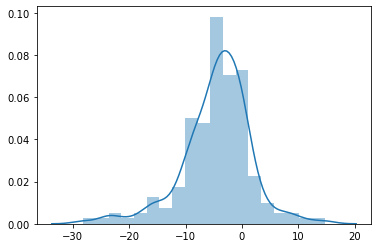

In [13]:
import seaborn as sns

sns.distplot(list(A.values()));

In [14]:
er = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [15]:
model.fit_generator(IGenerator(keys=tr_p, 
                               a = A, 
                               tab = TAB), 
                    steps_per_epoch = 200,
                    validation_data=IGenerator(keys=vl_p, 
                               a = A, 
                               tab = TAB),
                    validation_steps = 20, 
                    callbacks = [er], 
                    epochs=30)

Epoch 1/30
200/200 [==============================] - 90s 452ms/step - loss: 5.1886 - val_loss: 4.7484
Epoch 2/30
200/200 [==============================] - 81s 404ms/step - loss: 4.6955 - val_loss: 4.0408
Epoch 3/30
200/200 [==============================] - 76s 382ms/step - loss: 4.5063 - val_loss: 4.3889
Epoch 4/30
200/200 [==============================] - 74s 372ms/step - loss: 4.2824 - val_loss: 4.1987
Epoch 5/30
200/200 [==============================] - 74s 369ms/step - loss: 4.2587 - val_loss: 4.3738
Epoch 6/30
200/200 [==============================] - 74s 371ms/step - loss: 4.1384 - val_loss: 4.4573
Epoch 7/30
200/200 [==============================] - 74s 368ms/step - loss: 3.9211 - val_loss: 4.1391


In [16]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70)
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [29]:
model.save("/kaggle/working/model.h5")

In [17]:
from tqdm.notebook import tqdm

metric = []
for q in tqdm(range(1, 10)):
    m = []
    for p in vl_p:
        x = [] 
        tab = [] 
        
        if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
            continue
        for i in os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/'):
            x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
            tab.append(get_tab(train.loc[train.Patient == p, :])) 
        tab = np.array(tab) 
    
        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q / 10)
        
        percent_true = train.Percent.values[train.Patient == p]
        fvc_true = train.FVC.values[train.Patient == p]
        weeks_true = train.Weeks.values[train.Patient == p]
        
        fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
        percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
        m.append(score(fvc_true, fvc, percent))
    print(np.mean(m))
    metric.append(np.mean(m))

6.884095634886754
6.884139308414955
6.884193100979474
6.884259094208698
6.884346809422757
6.884417145286374
6.884493386500163
6.884630875388945
6.884721384358358



## Predict

In [18]:
q = (np.argmin(metric) + 1)/ 10
q

0.1

In [19]:
sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
sub.head() 

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [20]:
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [21]:
A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
STD, WEEK = {}, {} 
for p in test.Patient.unique():
    x = [] 
    tab = [] 
    for i in os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/'):
        x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
        tab.append(get_tab(test.loc[test.Patient == p, :])) 
    tab = np.array(tab) 
            
    x = np.expand_dims(x, axis=-1) 
    _a = model.predict([x, tab]) 
    a = np.quantile(_a, q)
    A_test[p] = a
    B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
    P_test[p] = test.Percent.values[test.Patient == p] 
    WEEK[p] = test.Weeks.values[test.Patient == p]

In [22]:
for k in sub.Patient_Week.values:
    p, w = k.split('_')
    w = int(w) 
    
    fvc = A_test[p] * w + B_test[p]
    sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
    sub.loc[sub.Patient_Week == k, 'Confidence'] = (
        P_test[p] - A_test[p] * abs(WEEK[p] - w) 
) 
    

In [23]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3086.571616,136.758471
1,ID00421637202311550012437_-12,2840.528492,183.573784
2,ID00422637202311677017371_-12,1996.262732,142.935225
3,ID00423637202312137826377_-12,3402.265602,187.524504
4,ID00426637202313170790466_-12,2971.196989,118.021957


In [24]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [31]:
from keras.models import load_model
model = load_model("/kaggle/working/model.h5")

In [32]:
model.summary()

AttributeError: 'Model' object has no attribute 'describe'